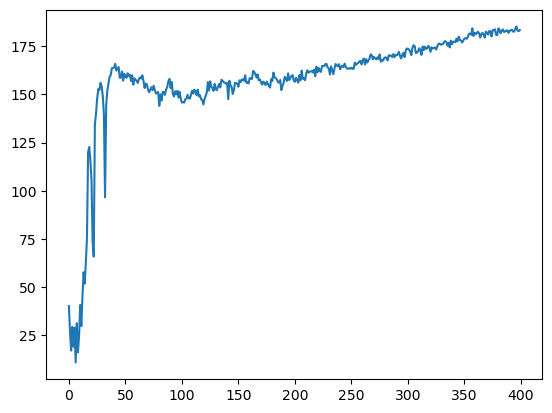

In [4]:
import numpy as np
import matplotlib.pyplot as plt
log = np.load("../model/log.npz")
plt.close("all")
plt.plot(log["true_values"])
# plt.yscale("log")
plt.show()
log.close()

In [5]:
import torch
import numpy as np
ds = T.simulate()
d = ds[0]
values = T.agent.critic(torch.from_numpy(d["obss"]).to(T.agent.device))
values = values.detach().cpu().numpy()

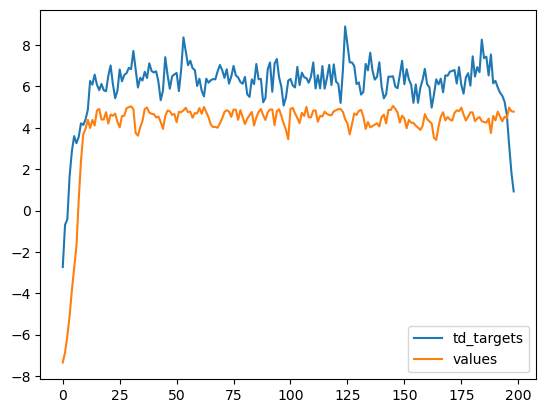

In [6]:
plt.close("all")
plt.plot(d["td_targets"], label="td_targets")
plt.plot(values, label="values")
plt.legend()
plt.show()

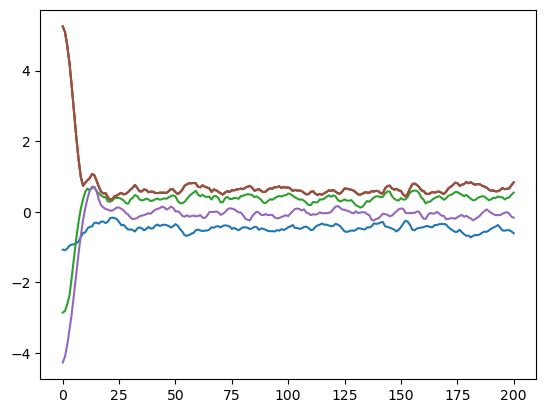

In [10]:
plt.close("all")
# d = ds[1]
d2o = np.linalg.norm(d["states"][:,:3], axis=1)
for i in range(3):
    plt.plot(d["states"][:,i])
    plt.plot(d2o)
plt.show()

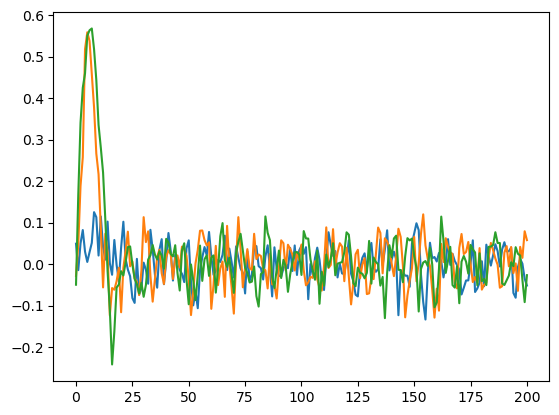

In [11]:
plt.close("all")
# d = ds[1]
d2o = np.linalg.norm(d["states"][:,:3], axis=1)
for i in range(3,6):
    plt.plot(d["states"][:,i])
plt.show()

In [1]:
from trainer.trainer import treeTrainer
from agent.agent import debugTreeAgent
from env.env import debugTreeEnv

import numpy as np
import matplotlib.pyplot as plt

pop = 200
max_gen = 200
env = debugTreeEnv(pop, max_gen, A=True)
agent = debugTreeAgent(actor_hiddens=[256]*4, critic_hiddens=[256]*4, actor_lr=1E-4, critic_lr=2E-4)
T = treeTrainer(env, agent, gamma=0.995)
#T.agent.load("../model/check_point3.ptd")

In [2]:
T.train(n_episode=4)

Output()

In [9]:
_, d = T.test(t_max=.01)
print(T.tree.gen)
print(T.testEnv.episode)

4
201
